In [14]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from zipfile import ZipFile

# Import label encoder
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

# PCA
from sklearn.decomposition import PCA

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

from tensorflow.keras.models import Model

**Part 1**

In [15]:
# import and read images

img_array = np.load('/content/drive/My Drive/Projects/CV P2/images.npy', allow_pickle=True)
type(img_array)

numpy.ndarray

In [16]:
print(img_array)

[[array([[[42, 37, 34],
          [56, 51, 48],
          [71, 66, 63],
          ...,
          [23, 33, 34],
          [26, 36, 37],
          [28, 38, 39]],

         [[40, 35, 32],
          [51, 46, 43],
          [64, 59, 56],
          ...,
          [27, 36, 35],
          [24, 33, 32],
          [26, 35, 34]],

         [[43, 38, 35],
          [51, 46, 43],
          [61, 56, 53],
          ...,
          [28, 30, 27],
          [33, 35, 32],
          [35, 37, 34]],

         ...,

         [[56, 47, 40],
          [57, 48, 41],
          [61, 52, 45],
          ...,
          [67, 48, 42],
          [55, 35, 28],
          [60, 40, 33]],

         [[53, 44, 37],
          [54, 45, 38],
          [57, 48, 41],
          ...,
          [59, 40, 34],
          [60, 40, 33],
          [54, 34, 27]],

         [[53, 44, 37],
          [54, 45, 38],
          [57, 48, 41],
          ...,
          [59, 40, 34],
          [70, 50, 43],
          [64, 44, 37]]], dtype=uint8)
  list

In [17]:
# Image Dataset Shape

images = img_array[:,0]
mask = img_array[:,1]
print(images.shape, mask.shape)

(409,) (409,)


In [18]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
ALPHA = 1

In [19]:
img_array.shape[0]

409

In [20]:
# X and y split of data and shape unified

y_masks = np.zeros((int(img_array.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_data = np.zeros((int(img_array.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(img_array.shape[0]):
    img = img_array[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_data[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in img_array[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        y_masks[index][y1:y2, x1:x2] = 1
X_data.shape

(409, 224, 224, 3)

In [21]:
y_masks.shape

(409, 224, 224)

In [22]:
# Splitting X and y data into train and test

X_train = X_data[0:400]


In [23]:

X_test = X_data[400:409]

In [24]:
X_test.shape

(9, 224, 224, 3)

In [25]:
X_train.shape

(400, 224, 224, 3)

In [26]:
y_train_masks = y_masks[0:400]
y_test_masks = y_masks[400:409]

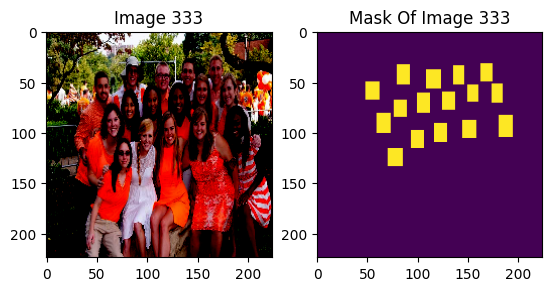

In [27]:
# Select random image from train data and display its original and masked image

n = 333
plt.subplot(1,2,1)
plt.title('Image 333')
plt.imshow(X_train[n])

plt.subplot(1,2,2)
plt.title('Mask Of Image 333')
plt.imshow(y_train_masks[n])

In [28]:
# Designing a face mask detection model

model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")
model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [29]:
# Model Creation : Combining pre-trained non-trainable layers of MobileNet with corresponding Upsampling layers to imitate UNET

def create_model(trainable=False):
    # Define the input tensor explicitly
    input_tensor = tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), name='input_image')

    # Instantiate MobileNet with the explicit input tensor
    model = MobileNet(input_tensor=input_tensor, include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    # Use the explicit input_tensor for block00
    block00 = input_tensor
    block01 = model.get_layer("conv_pw_1_relu").output
    block02 = model.get_layer("conv_pw_2_relu").output
    block03 = model.get_layer("conv_pw_3_relu").output
    block05 = model.get_layer("conv_pw_5_relu").output
    block11 = model.get_layer("conv_pw_11_relu").output
    block13 = model.get_layer("conv_pw_13_relu").output

    decoderBlock = Concatenate()([UpSampling2D()(block13), block11])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block05])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block03])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block01])
    decoderBlock = UpSampling2D()(decoderBlock)

    # Final concatenation with the original input tensor
    # Ensure all shapes match on non-concat axis
    decoderBlock = Concatenate()([decoderBlock, block00])

    decoderBlock = Conv2D(1, kernel_size=1, activation="sigmoid")(decoderBlock)
    decoderBlock = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(decoderBlock)

    return Model(inputs=input_tensor, outputs=decoderBlock)

In [30]:
# Display model summary

smodel = create_model()

# Print summary
model.summary()

/tmp/ipython-input-3688369620.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNet(input_tensor=input_tensor, include_top=False, alpha=ALPHA, weights="imagenet")


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [31]:
# Creating customised Dice Coefficient and Loss function

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [32]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [33]:
model = create_model(False)
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)
model.compile(loss=loss, optimizer = optimizer, metrics=[dice_coefficient], run_eagerly=True)

/tmp/ipython-input-3688369620.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNet(input_tensor=input_tensor, include_top=False, alpha=ALPHA, weights="imagenet")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1           │ (None, 112, 112,  │        288 │ conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_bn        │ (None, 112, 112,  │        128 │ conv_dw_1[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_relu      │ (None, 112, 112,  │          0 │ conv_dw_1_bn[0][… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1 (Conv2D)  │ (None, 112, 112,  │      2,048 │ conv_dw_1_relu[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_bn        │ (None, 112, 112,  │        256 │ conv_pw_1[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_relu      │ (None, 112, 112,  │          0 │ conv_pw_1_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pad_2          │ (None, 113, 113,  │          0 │ conv_pw_1_relu[0… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2           │ (None, 56, 56,    │        576 │ conv_pad_2[0][0]  │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_bn        │ (None, 56, 56,    │        256 │ conv_dw_2[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_relu      │ (None, 56, 56,    │          0 │ conv_dw_2_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2 (Conv2D)  │ (None, 56, 56,    │      8,192 │ conv_dw_2_relu[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_bn        │ (None, 56, 56,    │        512 │ conv_pw_2[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_relu      │ (None, 56, 56,    │          0 │ conv_pw_2_bn[0][

 Total params: 3,230,852 (12.32 MB)

 Trainable params: 1,988 (7.77 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [34]:
# model checkpoint callback saving the weights of the model along with the structure when there is no decrease in loss
checkpoint = ModelCheckpoint("model-{loss:.2f}.weights.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)

# If Loss does not decrease over 5 epochs, training would stop
stop = EarlyStopping(monitor="loss", patience=5, mode="min")

# If Loss does not decrease over 1 epoch, learning rate would reduce by 20%
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=1, min_lr=1e-6, verbose=1, mode="min")

In [35]:
# Fit model on train dataset

model.fit(X_train,y_train_masks,epochs = 5,verbose=1,batch_size=3)

Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 924s 7s/step - dice_coefficient: 0.1954 - loss: 2.4026
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 907s 7s/step - dice_coefficient: 0.3481 - loss: 1.4460
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 908s 7s/step - dice_coefficient: 0.4352 - loss: 1.1349
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 925s 7s/step - dice_coefficient: 0.4870 - loss: 1.0130
Epoch 5/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 938s 7s/step - dice_coefficient: 0.5123 - loss: 0.9286


A dice coefficient of about 51.23 % obtained which means the dice huge is low as 97.86 % with just 5 epochs.

In [36]:
# Predict on a test image at index 3

sample_image = X_test[3]
print(sample_image)

[[[ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  ...
  [-0.1607843  -0.01176471  0.10588241]
  [-0.09019607  0.06666672  0.1686275 ]
  [ 0.07450986  0.22352946  0.33333337]]

 [[ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  ...
  [-0.1607843  -0.01176471  0.10588241]
  [-0.09019607  0.05882359  0.1686275 ]
  [ 0.07450986  0.22352946  0.33333337]]

 [[ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  ...
  [-0.1607843  -0.01176471  0.10588241]
  [-0.09019607  0.05882359  0.1686275 ]
  [ 0.07450986  0.22352946  0.33333337]]

 ...

 [[ 0.68627453  0.53725493  0.4666667 ]
  [ 0.60000002  0.47450984  0.37254906]
  [ 0.72549021  0.58431375  0.48235297]
  ...
  [ 0.33333337  0.32549024  0.29411769]
  [ 0.3176471   0.29411769  0.3176471 ]
  [ 0.37254906  0.36470592  0.34901965]]

 [

In [ ]:
sample_image.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


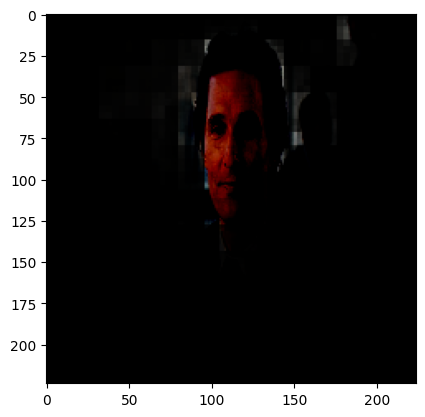

In [38]:
# Trained Model Predicting Masked Image from a sample image

pred_mask = model.predict(x=np.array([sample_image]))
out_image = sample_image
out_image[:,:,0] = pred_mask*sample_image[:,:,0]
out_image[:,:,1] = pred_mask*sample_image[:,:,1]
out_image[:,:,2] = pred_mask*sample_image[:,:,2]

#out_image = image

plt.imshow(out_image)

**Part 2**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import zipfile
import os

# Path to your zip file in Google Drive
zip_path = '/content/drive/My Drive/Projects/CV P2/training_images.zip'

# Destination folder to extract files
extract_path = '/content/drive/My Drive/Projects/CV P2/'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Unzipped successfully!


In [ ]:
TRAIN_DIRC = '/content/drive/My Drive/Projects/CV P2/training_images'

In [ ]:
# Read images from the extracted training images set, detect all faces one by one using the 'haarcascade_frontalface_default.xml' file from open source and extract metadata for each of those faces and store in a dataframe

X = []
faces_count = []
Img_name = []
df = pd.DataFrame(columns=['Image Name', 'Total_Faces', 'x', 'y', 'w', 'h'])
a = []
b = []
c = []
d = []


face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/Projects/CV P2/haarcascade_frontalface_default.xml')

for image_name in os.listdir(TRAIN_DIRC):
  # read each image inside train directory one by one
  image = cv2.imread(os.path.join(TRAIN_DIRC, image_name))
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  for (x,y,w,h) in faces:
    faces_count.append(len(faces))
    Img_name.append(image_name)
    a.append(x)
    b.append(y)
    c.append(w)
    d.append(h)
    image = cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
    X.append(image)

df['Total_Faces'] = faces_count
df['Image Name'] = Img_name
df['x'] = a
df['y'] = b
df['w'] = c
df['h'] = d

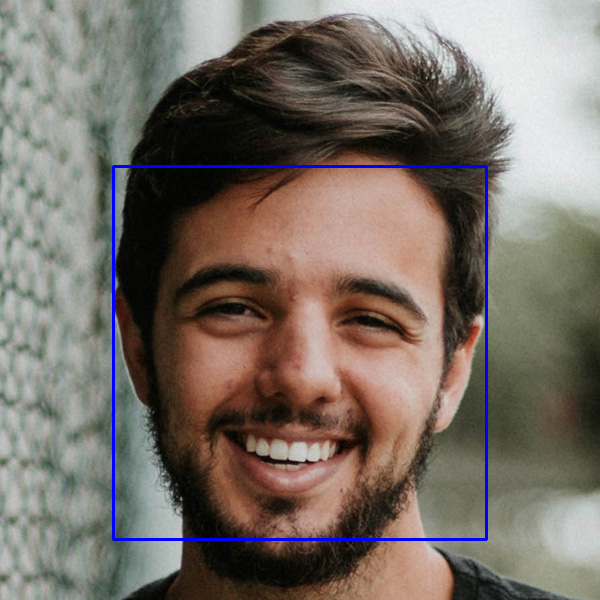

In [ ]:
# Images with localized face

from google.colab.patches import cv2_imshow

cv2_imshow(X[693])

In [ ]:
df.head(200)

Image Name  Total_Faces    x    y    w    h
0    real_01042.jpg            1   52  143  389  389
1    real_00964.jpg            1   65  119  430  430
2    real_01053.jpg            1   63   51  484  484
3    real_01057.jpg            1  114  157  389  389
4    real_01044.jpg            1  163  155  388  388
..              ...          ...  ...  ...  ...  ...
195  real_00717.jpg            1  246  164  331  331
196  real_00660.jpg            1  152  162  395  395
197  real_00647.jpg            1  118  126  383  383
198  real_00740.jpg            1   22  134  393  393
199  real_00672.jpg            1  326  183  141  141

[200 rows x 6 columns]

In [ ]:
# Only one image has 2 faces detected from the dataset of face images, all others have only 1 face detected

df['Total_Faces'].value_counts()

Total_Faces
1    692
2      2
Name: count, dtype: int64

In [ ]:

# The image with 2 faces detected'

df_new = df[df['Total_Faces'] == 2]
print(df_new)

         Image Name  Total_Faces    x    y    w    h
208  real_00735.jpg            2  507  165   59   59
209  real_00735.jpg            2   73  150  393  393


In [ ]:
df.shape

(694, 6)

In [ ]:
# Saving the output dataframe in .csv format

df.to_csv('file1.csv')


**Part 3**

In [ ]:
# Uzip and extract Dataset

with ZipFile('/content/drive/My Drive/Projects/CV P2/PINS.zip', 'r') as zipObj:
  zipObj.extractall('/content/drive/My Drive/Projects/CV P2/PINS_extracted')

In [ ]:
# Read & Load Data function

def load_image(path):
  image = cv2.imread(path, 1)
  # in BGR order. So we need to reverse them
  return image[...,::-1]

In [ ]:
# Defining MetaData Extraction Class with inbuilt image_path function for metadata creation from dataset. Metadata to be used for loading the images from dataset in future code

class MetaDataExtraction():
  def __init__(self, base, name, file):
    self.base = base
    self.name = name
    self.file = file

  def __repr__(self):
    return self.image_path()

  def image_path(self):
    return os.path.join(self.base, self.name, self.file)

In [ ]:

# Creating loop for metadata creation for the dataset

def create_metadata(path):
  metadata = []
  for i in os.listdir(path):
    for f in os.listdir(os.path.join(path, i)):
      # Check file extension. Allow only jpg/jpeg' files.
      ext = os.path.splitext(f)[1]
      if ext == '.jpg' or ext == '.jpeg':
        metadata.append(MetaDataExtraction(path, i, f))
  return np.array(metadata)

metadata = create_metadata('/content/drive/My Drive/Projects/CV P2/PINS_extracted/PINS')

In [ ]:
len(metadata)

10770

In [ ]:
print(metadata)

[/content/drive/My Drive/Projects/CV P2/PINS_extracted/PINS/pins_mark zuckerberg/mark zuckerberg1.jpg
 /content/drive/My Drive/Projects/CV P2/PINS_extracted/PINS/pins_mark zuckerberg/mark zuckerberg50.jpg
 /content/drive/My Drive/Projects/CV P2/PINS_extracted/PINS/pins_mark zuckerberg/mark zuckerberg44.jpg
 ...
 /content/drive/My Drive/Projects/CV P2/PINS_extracted/PINS/pins_tati gabrielle/tati gabrielle21.jpg
 /content/drive/My Drive/Projects/CV P2/PINS_extracted/PINS/pins_tati gabrielle/tati gabrielle20.jpg
 /content/drive/My Drive/Projects/CV P2/PINS_extracted/PINS/pins_tati gabrielle/tati gabrielle34.jpg]


In [ ]:
# Function for Creating Embedding Vectors of each face using VGG Face Model in Keras

def vgg_face_detection():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [ ]:
# Loading VGG weights onto the VGG face Model instance created

model = vgg_face_detection()
model.load_weights('/content/drive/My Drive/Projects/CV P2/vgg_face_weights.h5')

In [ ]:

# Get model upto last flatten layer #with outputs 2622 units

vgg_face_detection_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
type(vgg_face_detection_descriptor)

keras.src.models.functional.Functional

In [ ]:
# Input and Output for the defined VGG Face model

vgg_face_detection_descriptor.inputs, vgg_face_detection_descriptor.outputs

([<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1484>],
 [<KerasTensor shape=(None, 2622), dtype=float32, sparse=False, ragged=False, name=keras_tensor_2187>])

In [ ]:
# Creating loop for extracting embedding vectors for each image in the dataset using

embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    image_path = metadata[i].image_path()
    image = load_image(image_path)
    image = (image / 255.).astype(np.float32)
    image = cv2.resize(image, dsize = (224,224))
    embedding_vector = vgg_face_detection_descriptor.predict(np.expand_dims(image, axis=0))[0]
    embeddings[i] = embedding_vector

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━

In [ ]:
embedding_vector

array([ 0.00170651, -0.00516734,  0.0076349 , ..., -0.00594632,
        0.01564093,  0.01497152], dtype=float32)

In [37]:
# printing shape, sample value, type and value type of embedding vector
print(embedding_vector.shape)
embedding_vector[0], type(embedding_vector), type(embedding_vector[0])

(2622,)


(np.float32(0.0017065105), numpy.ndarray, numpy.float32)

In [38]:
embeddings

array([[ 0.0142315 ,  0.00407746, -0.00861885, ..., -0.00646766,
         0.00643114,  0.01167792],
       [ 0.02057642,  0.01755632,  0.00602331, ..., -0.01006831,
         0.01327197, -0.00172878],
       [ 0.0079851 ,  0.03663671,  0.02346714, ..., -0.00569295,
         0.01663852,  0.01722093],
       ...,
       [ 0.00524247, -0.00241521, -0.00201711, ..., -0.01148475,
         0.02080981,  0.01842145],
       [-0.00059405, -0.00626452, -0.00454   , ..., -0.00601336,
         0.01052898,  0.01700823],
       [ 0.00170651, -0.00516734,  0.0076349 , ..., -0.00594632,
         0.01564093,  0.01497152]])

In [39]:
type(embeddings)

numpy.ndarray

In [40]:
pd.DataFrame(embeddings).to_csv('/content/drive/My Drive/Projects/CV P2/image_embeddings.csv', index = False)
embeddings = (pd.read_csv('/content/drive/My Drive/Projects/CV P2/image_embeddings.csv')).to_numpy()

In [41]:
type(metadata[0])

__main__.MetaDataExtraction

In [42]:
metadata

array([/content/drive/My Drive/Projects/CV P2/PINS_extracted/PINS/pins_mark zuckerberg/mark zuckerberg1.jpg,
       /content/drive/My Drive/Projects/CV P2/PINS_extracted/PINS/pins_mark zuckerberg/mark zuckerberg50.jpg,
       /content/drive/My Drive/Projects/CV P2/PINS_extracted/PINS/pins_mark zuckerberg/mark zuckerberg44.jpg,
       ...,
       /content/drive/My Drive/Projects/CV P2/PINS_extracted/PINS/pins_tati gabrielle/tati gabrielle21.jpg,
       /content/drive/My Drive/Projects/CV P2/PINS_extracted/PINS/pins_tati gabrielle/tati gabrielle20.jpg,
       /content/drive/My Drive/Projects/CV P2/PINS_extracted/PINS/pins_tati gabrielle/tati gabrielle34.jpg],
      dtype=object)

In [43]:
embeddings[0]

array([ 0.0142315 ,  0.00407746, -0.00861885, ..., -0.00646766,
        0.00643114,  0.01167792])

In [44]:
# Build distance metrics for identifying the distance between two similar and dissimilar images

def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [47]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance between {idx1} & {idx2}= {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));

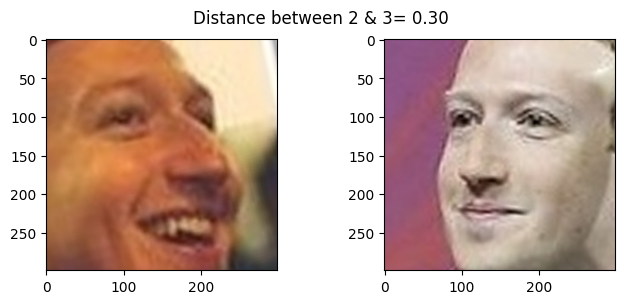

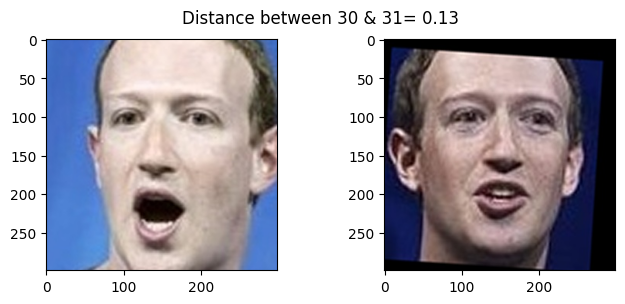

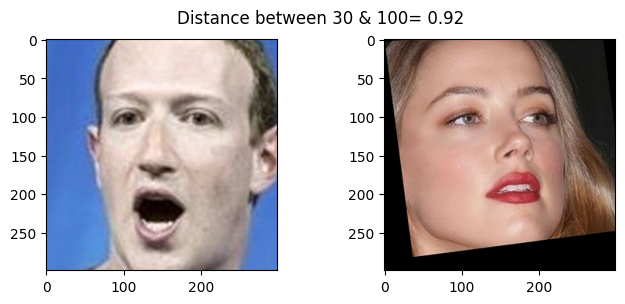

In [48]:
show_pair(2, 3)
show_pair(30, 31)
show_pair(30,100)

In [49]:

train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

In [50]:
# Label encoding the labels

encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [51]:
# Standarize features

scaler = preprocessing.StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [52]:
X_train_sc.shape

(9573, 2622)

In [53]:
# Covariance matrix required for PCA Analysis

covMatrix = np.cov(X_train_sc,rowvar=False)
print(covMatrix)

[[ 1.00010447  0.11741681  0.10520056 ...  0.07831524 -0.12323812
  -0.25336857]
 [ 0.11741681  1.00010447  0.23340627 ... -0.03385239  0.28069846
   0.21756522]
 [ 0.10520056  0.23340627  1.00010447 ... -0.11338914  0.06516705
   0.04161968]
 ...
 [ 0.07831524 -0.03385239 -0.11338914 ...  1.00010447 -0.02452562
  -0.097309  ]
 [-0.12323812  0.28069846  0.06516705 ... -0.02452562  1.00010447
   0.39234903]
 [-0.25336857  0.21756522  0.04161968 ... -0.097309    0.39234903
   1.00010447]]


In [54]:
pca = PCA(n_components = 400)
pca.fit(X_train_sc)

PCA(n_components=400)

In [55]:

# Percentage of variation explained by each Eigen Vector

print(pca.explained_variance_ratio_)

[1.35641927e-01 5.39397576e-02 3.97474783e-02 3.64946879e-02
 3.42040174e-02 3.11443307e-02 2.56904188e-02 2.36006177e-02
 2.09847015e-02 1.92830498e-02 1.82752813e-02 1.71084775e-02
 1.66190479e-02 1.55669864e-02 1.41574885e-02 1.37338700e-02
 1.30915440e-02 1.23256652e-02 1.16260441e-02 1.13326593e-02
 1.09917198e-02 1.05221346e-02 9.65396193e-03 9.44639477e-03
 9.19317070e-03 8.85024936e-03 8.37360147e-03 7.62812111e-03
 7.58772734e-03 7.38742728e-03 7.03431331e-03 6.61821197e-03
 6.37278118e-03 6.18635395e-03 5.70241365e-03 5.39184117e-03
 5.24790609e-03 5.18226191e-03 5.04050984e-03 4.81219557e-03
 4.39281029e-03 4.34792759e-03 3.96700111e-03 3.93870947e-03
 3.69405368e-03 3.54950694e-03 3.43777640e-03 3.35851856e-03
 3.26484093e-03 3.16289871e-03 3.12741226e-03 3.09207224e-03
 2.88942270e-03 2.82947305e-03 2.80544840e-03 2.72012582e-03
 2.69985356e-03 2.61707904e-03 2.52477735e-03 2.48289327e-03
 2.39052634e-03 2.32532860e-03 2.25274260e-03 2.14658034e-03
 2.10608175e-03 2.056769

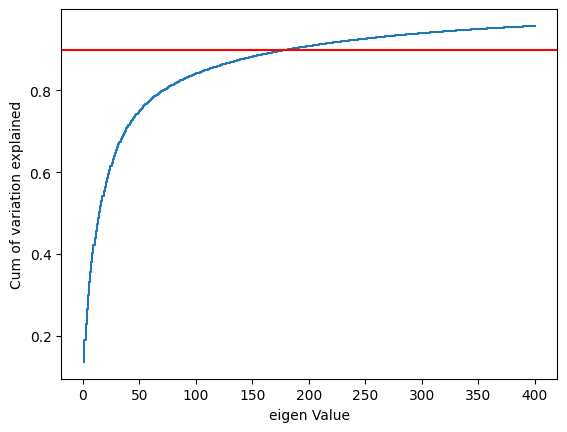

In [56]:
# % cumulative variance explained using PCA with respect to the eigen values

from matplotlib import pyplot as plt

plt.step(range(1,401),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.axhline(y = 0.9, color = 'r', linestyle = '-')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

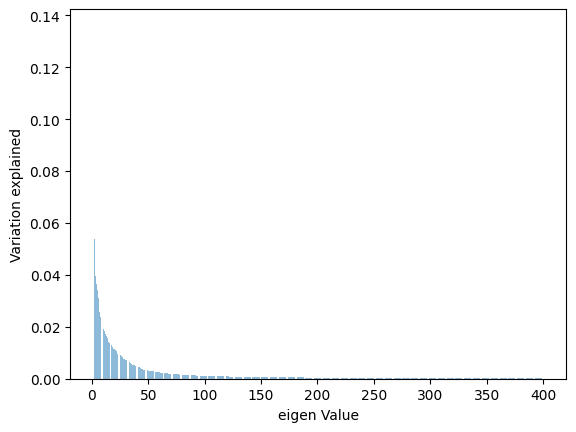

In [57]:
plt.bar(range(1,401),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

In [58]:
# Applying 125 principal components to fit the Scaled and balanced X data

pca_125 = PCA(n_components = 125)
pca_125.fit(X_train_sc)
print(pca_125.components_, "\n\n")
print(pca_125.explained_variance_ratio_)
X_train_sc_pca_125 = pca_125.transform(X_train_sc)
X_test_sc_pca_125 = pca_125.transform(X_test_sc)

[[-0.02388654  0.00890806 -0.00295928 ... -0.00836134  0.02113652
   0.03889363]
 [-0.02085526  0.00135592 -0.00804418 ...  0.02309182  0.00477625
  -0.01099284]
 [-0.00354109 -0.00248615  0.00719563 ... -0.01067462  0.00090444
   0.01552429]
 ...
 [-0.03777208 -0.01162761  0.03222886 ... -0.00303442 -0.01460945
  -0.02369745]
 [-0.01150694  0.00353275 -0.04618443 ...  0.01497397 -0.00385577
  -0.01080148]
 [ 0.00654835 -0.00194092 -0.00699516 ... -0.006579   -0.01732831
  -0.02809652]] 


[0.13564193 0.05393976 0.03974748 0.03649469 0.03420402 0.03114433
 0.02569042 0.02360062 0.0209847  0.01928305 0.01827528 0.01710848
 0.01661905 0.01556699 0.01415749 0.01373387 0.01309154 0.01232567
 0.01162604 0.01133266 0.01099172 0.01052213 0.00965396 0.00944639
 0.00919317 0.00885025 0.0083736  0.00762812 0.00758773 0.00738743
 0.00703431 0.00661821 0.00637278 0.00618635 0.00570241 0.00539184
 0.00524791 0.00518226 0.00504051 0.0048122  0.00439281 0.00434793
 0.003967   0.00393871 0.00369405 0.

In [59]:
# SVC model created and fit on PCA transformed trainset

from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Set random_state
random_state = 2020

svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_sc_pca_125, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_sc_pca_125, y_train)))

SVC accuracy for train set: 0.999


In [61]:
# Predict
y_pred = svc_pca.predict(X_test_sc_pca_125)

# Accuracy Score
print('Test Accuracy Score: {}'.format(round(accuracy_score(y_test, y_pred), 3)))

Test Accuracy Score: 0.953


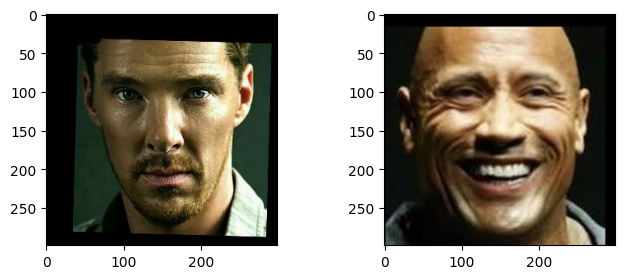

In [62]:
# Predict for 2 specific example images

image_path_1 = '/content/drive/My Drive/Projects/CV P2/Benedict Cumberbatch9.jpg'
image_path_2 = '/content/drive/My Drive/Projects/CV P2/Dwayne Johnson4.jpg'

image_1 = load_image(image_path_1)
image_2 = load_image(image_path_2)

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.imshow(image_1)
plt.subplot(122)
plt.imshow(image_2)

In [63]:
# Normalize, Resize and create embedding vectors for example images for model prediction

image_1 = (image_1 / 255.).astype(np.float32)
image_1 = cv2.resize(image_1, dsize = (224,224))
embedding_vector_1 = vgg_face_detection_descriptor.predict(np.expand_dims(image_1, axis=0))[0]

image_2 = (image_2 / 255.).astype(np.float32)
image_2 = cv2.resize(image_2, dsize = (224,224))
embedding_vector_2 = vgg_face_detection_descriptor.predict(np.expand_dims(image_2, axis=0))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


In [64]:

# Reshape embedding vectors of 2 example images
embedding_vector_1 = np.reshape(embedding_vector, (1, 2622))
embedding_vector_2 = np.reshape(embedding_vector, (1, 2622))
embedding_vector_1.shape

(1, 2622)

In [65]:
# Scale embedding vectors

embedding_vector_sc_1 = scaler.fit_transform(embedding_vector_1)
embedding_vector_pca_1 = pca_125.transform(embedding_vector_sc_1)

embedding_vector_sc_2 = scaler.fit_transform(embedding_vector_2)
embedding_vector_pca_2 = pca_125.transform(embedding_vector_sc_2)

In [66]:
# Predict from transformed embedding vectors for 2 example images

y_pred_1 = svc_pca.predict(embedding_vector_pca_1)
y_pred_2 = svc_pca.predict(embedding_vector_pca_2)

print ('Prediction for Image 1 - Benedict Cumberbatch : ', y_pred_1)
print ('Prediction for Image 2 - Dwayne Johnson : ', y_pred_2)

Prediction for Image 1 - Benedict Cumberbatch :  [89]
Prediction for Image 2 - Dwayne Johnson :  [89]
